In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import seaborn as sns
from wordcloud import wordcloud
from tensorflow.keras import layers,models,losses, Sequential, optimizers, metrics
import tensorflow
import keras
import plotly.express as px
import plotly.graph_objects as go

In [2]:


print(tensorflow.__version__)

2.17.1


In [3]:

print(keras.__version__)

3.5.0


# Import data

In [4]:
twt_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sent Analysis/Tweets.csv')
twt_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
twt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
twt_df = twt_df.dropna()

In [7]:
# Check for null values in each column
twt_df.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [8]:
twt_df.duplicated().sum()

0

In [9]:

# Drop selected text and textid
twt_df = twt_df.drop(columns = ["selected_text", "textID"])

In [10]:
twt_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [11]:
twt_df["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [12]:

# Calculate value counts and reset index for Plotly Express
sentiment_counts = twt_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']  # Rename columns

# Create the bar chart
fig = px.bar(
    sentiment_counts,
    x='sentiment',
    y='count',
    title='Distribution of Sentiments',
    labels={'sentiment': 'Sentiment', 'count': 'Number of Tweets'}
)
fig.show()

In [13]:
# obtain word count feature
twt_df["word_count"] = twt_df["text"].apply(lambda x: len(x.split(" ")))

In [14]:
twt_df.head()

,text,sentiment,word_count
0,"I`d have responded, if I were going",neutral,8
1,Sooo SAD I will miss you here in San Diego!!!,negative,11
2,my boss is bullying me...,negative,5
3,what interview! leave me alone,negative,6
4,"Sons of ****, why couldn`t they put them on t...",negative,15


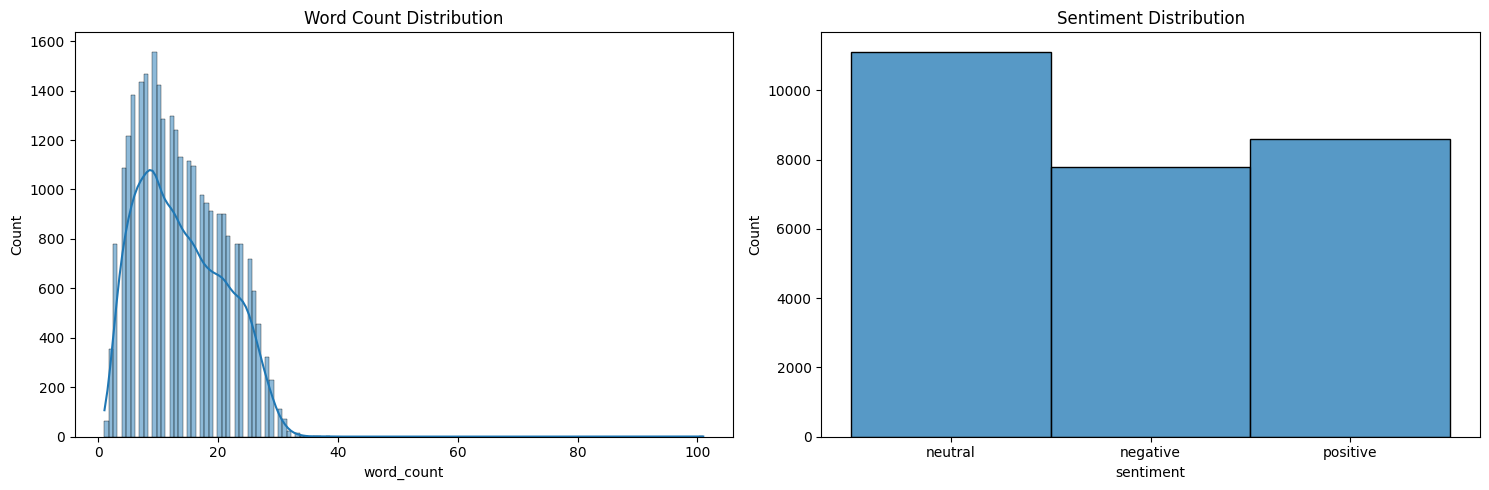

In [15]:
# prompt: create historgram plot of word_count and sentiment

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot word_count histogram
sns.histplot(twt_df['word_count'], ax=axes[0], kde=True)
axes[0].set_title('Word Count Distribution')

# Plot sentiment histogram
sns.histplot(twt_df['sentiment'], ax=axes[1])
axes[1].set_title('Sentiment Distribution')

plt.tight_layout()
plt.show()

<Axes: ylabel='word_count'>

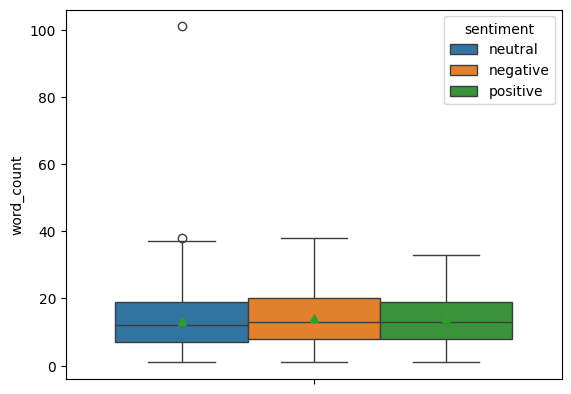

In [16]:
sns.boxplot(twt_df,y = "word_count", hue = "sentiment", showmeans = True)

In [17]:


fig = go.Figure()

for sentiment, data in twt_df.groupby('sentiment'):
    fig.add_trace(go.Box(y=data['word_count'], name=sentiment, boxmean='sd'))

fig.show()


#Cleaning and Preprocessing Text

In [18]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
import string
def tensor_to_string(tensor):
    return tensor.numpy().decode('utf-8')
def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

In [20]:
twt_df["text"][0]

' I`d have responded, if I were going'

In [21]:
custom_standardization(twt_df["text"][0]).numpy()

b'  responded going'

In [22]:
# create a new column
twt_df["processed_text"] = twt_df['text'].apply(custom_standardization)

# convert tensor to string
twt_df["processed_text"] = twt_df["processed_text"].apply(tensor_to_string)

In [23]:
twt_df.head()

,text,sentiment,word_count,processed_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought


# Obtain frequency of words for Sentiment

In [24]:
positive_twt = twt_df[twt_df["sentiment"] == "positive"]
negative_twt = twt_df[twt_df["sentiment"] == "negative"]
neutral_twt = twt_df[twt_df["sentiment"] == "neutral"]

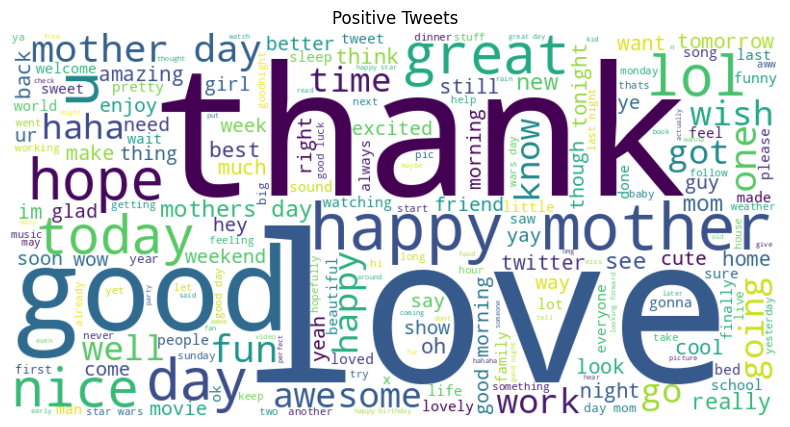

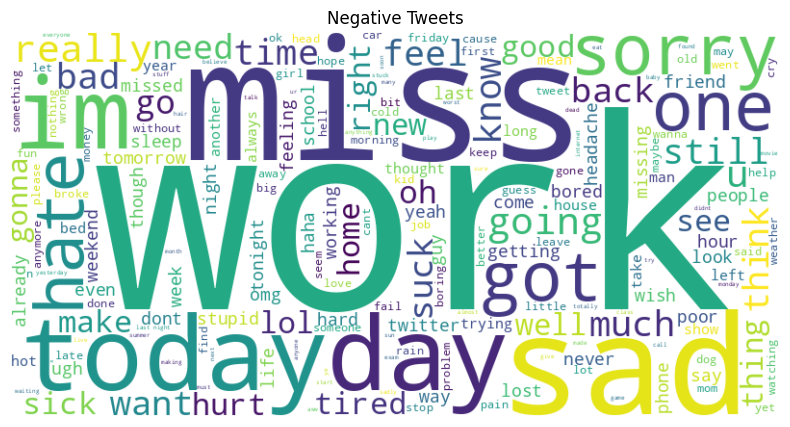

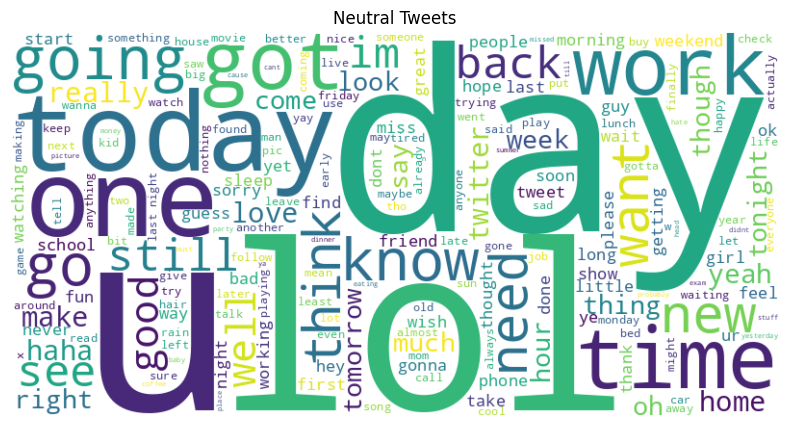

In [25]:
# prompt: create word cloud for posiitve_twt, negative and neutral /

from wordcloud import WordCloud

# Function to create and display a word cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create word clouds for each sentiment
create_wordcloud(positive_twt['processed_text'], 'Positive Tweets')
create_wordcloud(negative_twt['processed_text'], 'Negative Tweets')
create_wordcloud(neutral_twt['processed_text'], 'Neutral Tweets')

In [26]:
# convert sentiment to numeric
twt_df["sentiment"] = twt_df["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2})


<ipython-input-26-7db9928389ec>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(twt_df, test_size = 0.2, stratify = twt_df["sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((19785, 4), (2199, 4), (5496, 4))

In [28]:
twt_df.head()

,text,sentiment,word_count,processed_text
0,"I`d have responded, if I were going",1,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,0,11,sooo sad miss san diego
2,my boss is bullying me...,0,5,boss bullying
3,what interview! leave me alone,0,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",0,15,sons put releases already bought


In [29]:
twt_df[twt_df["sentiment"] == 2]

,text,sentiment,word_count,processed_text
6,2am feedings for the baby are fun when he is a...,2,14,feedings baby fun smiles coos
9,Journey!? Wow... u just became cooler. hehe....,2,12,journey wow u became cooler hehe possible
11,I really really like the song Love Story by Ta...,2,11,really really like song love story taylor swift
21,Playing Ghost Online is really interesting. Th...,2,25,playing ghost online really interesting new up...
25,"the free fillin` app on my ipod is fun, im add...",2,11,free fillin app ipod fun im addicted
...,...,...,...,...
27467,morning twit-friends! welcome to my new followers,2,7,morning twitfriends welcome new followers
27474,So I get up early and I feel good about the da...,2,27,get early feel good day walk work feeling al...
27475,enjoy ur night,2,5,enjoy ur night
27478,Yay good for both of you. Enjoy the break - y...,2,24,yay good enjoy break probably need hectic w...


twt_df.head()

In [30]:
X_train["sentiment"].value_counts()

,count
sentiment,
1,8005
2,6178
0,5602


In [31]:
X_val["sentiment"].value_counts()

,count
sentiment,
1,889
2,687
0,623


In [32]:
X_test["sentiment"].value_counts()

,count
sentiment,
1,2223
2,1717
0,1556


# Train and test data

In [33]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["text"].values, X_train["sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["text"].values, X_val["sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["text"].values, X_test["sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

(155, 18, 43)

# Vectorize text

In [34]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

In [35]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

In [36]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

In [37]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b'well.. i just saw the dead zone for the first time. its a good TV show.  is back', shape=(), dtype=string)
Sentiment:  neutral
Vectorized review:  (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=
array([[6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Apply Text Vectorization

In [38]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Define your DNN

In [40]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

# Model parameters

In [41]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

# Train DNN Model

In [42]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = train_ds)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.4165 - loss: 1.0854 - val_accuracy: 0.5292 - val_loss: 1.0240
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5688 - loss: 1.0051 - val_accuracy: 0.6822 - val_loss: 0.9180
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6791 - loss: 0.8975 - val_accuracy: 0.7303 - val_loss: 0.8068
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7201 - loss: 0.7937 - val_accuracy: 0.7567 - val_loss: 0.7179
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7482 - loss: 0.7138 - val_accuracy: 0.7769 - val_loss: 0.6500
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7670 - loss: 0.6523 - val_accuracy: 0.7925 - val_loss: 0.5961
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7840 - loss: 0.6034 - val_accuracy: 0.8074 - val_loss: 0.5513
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7971 - loss: 0.5632 - val_ac

In [43]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.6903 - loss: 0.7808
Loss:  0.7925407290458679
Accuracy:  0.6875909566879272


In [44]:
history_dict = history.history

history_dict

{'accuracy': [0.4497852027416229,
  0.595299482345581,
  0.687894880771637,
  0.7261561751365662,
  0.7508718967437744,
  0.7690169215202332,
  0.7857972979545593,
  0.7995956540107727,
  0.8135961294174194,
  0.8259287476539612],
 'loss': [1.0700397491455078,
  0.9823401570320129,
  0.8735206127166748,
  0.7747109532356262,
  0.6991304159164429,
  0.6402446627616882,
  0.5926438570022583,
  0.5522249341011047,
  0.5176314115524292,
  0.486678808927536],
 'val_accuracy': [0.529239296913147,
  0.6821834444999695,
  0.7302501797676086,
  0.7566843628883362,
  0.7769017219543457,
  0.7925195693969727,
  0.8073793053627014,
  0.8209754824638367,
  0.8328026533126831,
  0.8459944128990173],
 'val_loss': [1.0239636898040771,
  0.9179881811141968,
  0.8067702651023865,
  0.7179440855979919,
  0.65003502368927,
  0.5960771441459656,
  0.5512915849685669,
  0.5132437348365784,
  0.4801945090293884,
  0.45032477378845215]}

# Training and Validation Loss Evaluation

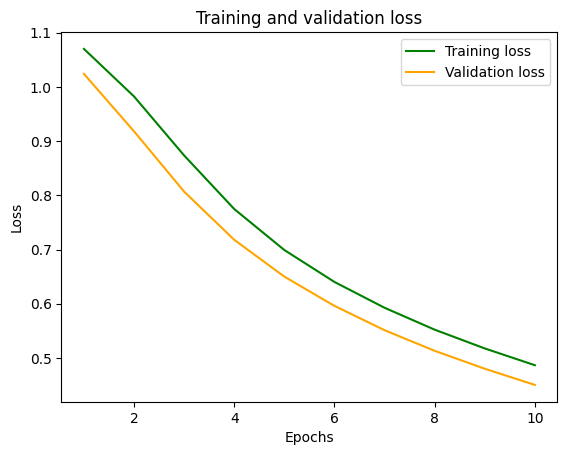

In [45]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Training and Validation Accuracy Evaluation

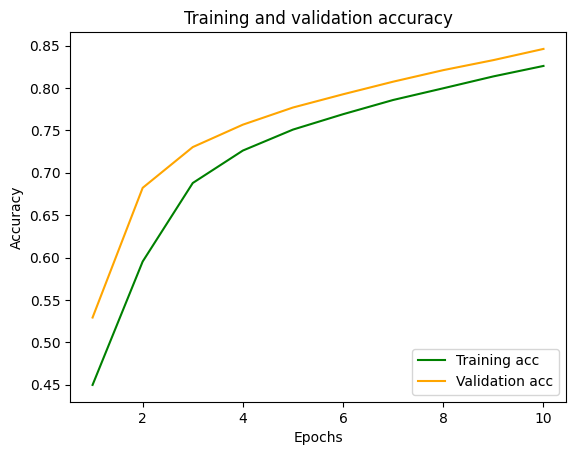

In [46]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [47]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
results = export_model.evaluate(raw_test_ds)
# print(accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.6903 - loss: 0.0000e+00


In [48]:
results

[0.0, 0.0, 0.6875909566879272, 0.6875909566879272]

In [49]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      1556
           1       0.63      0.74      0.68      2223
           2       0.76      0.71      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496



#Train using tf-idf

In [50]:
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [51]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [52]:
tfidf_vectorizer.adapt(text)

In [53]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

In [54]:
tfidf_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0.        , 0.6931472 , 1.6945957 , 0.        , 0.        ,
        1.0986123 , 0.        , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 , 1.0986123 , 1.0986123 ],
       [0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.0986123 , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.6931472 , 0.84729785, 0.84729785, 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0

In [55]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

In [56]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

In [57]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

In [58]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [59]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# DNN Model

In [60]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - accuracy: 0.3308 - loss: 1.1433 - val_accuracy: 0.3847 - val_loss: 1.0978
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.3773 - loss: 1.1102 - val_accuracy: 0.4170 - val_loss: 1.0838
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4068 - loss: 1.0936 - val_accuracy: 0.4420 - val_loss: 1.0710
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4277 - loss: 1.0752 - val_accuracy: 0.4657 - val_loss: 1.0588
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4562 - loss: 1.0589 - val_accuracy: 0.4870 - val_loss: 1.0466
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4763 - loss: 1.0417 - val_accuracy: 0.5034 - val_loss: 1.0344
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4979 - loss: 1.0241 - val_accuracy: 0.5234 - val_loss: 1.0221
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5185 - loss: 1.0079 - val_a

In [61]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.6593 - loss: 0.7962
Loss:  0.8087697625160217
Accuracy:  0.6552037596702576


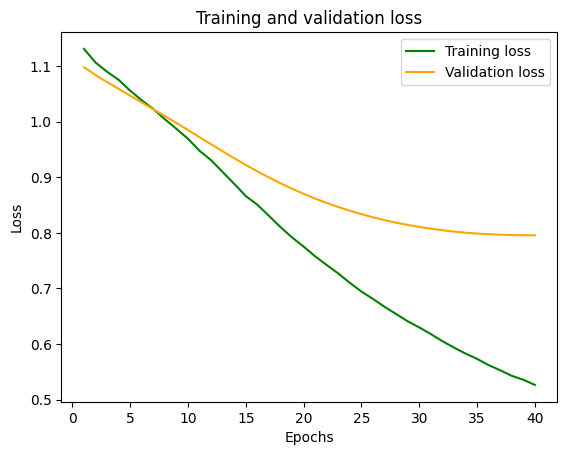

In [62]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

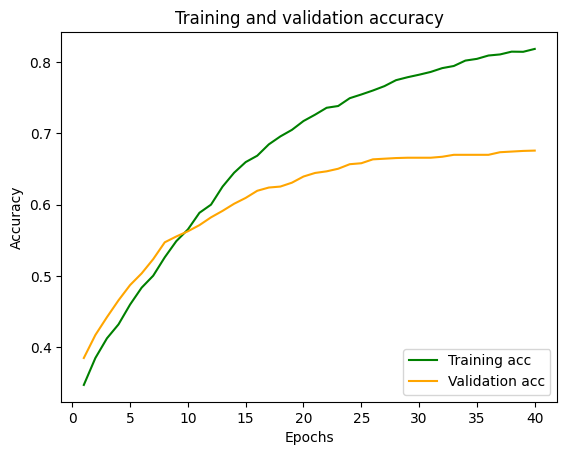

In [63]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [64]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
results = export_model.evaluate(raw_test_ds)
# print(accuracy)
results

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.6593 - loss: 0.0000e+00


[0.0, 0.0, 0.6552037596702576, 0.6552037596702576]

# Represent text using integer seqeunces

In [65]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [66]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [67]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [68]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Training ADNN using embeddings

In [70]:

callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 3,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 1,
        factor = 0.1,
    )
]

In [71]:
embedding_dim = 64

model = Sequential([
  layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(32, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(3)]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])

history = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callback_list
)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.3999 - loss: 1.0910 - val_accuracy: 0.4043 - val_loss: 1.0869 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4040 - loss: 1.0878 - val_accuracy: 0.4043 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.4045 - loss: 1.0860 - val_accuracy: 0.4043 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4043 - loss: 1.0841 - val_accuracy: 0.4043 - val_loss: 1.0813 - learning_rate: 1.0000e-04


In [73]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3930 - loss: 1.0849
Loss:  1.0815799236297607
Accuracy:  0.40447598695755005


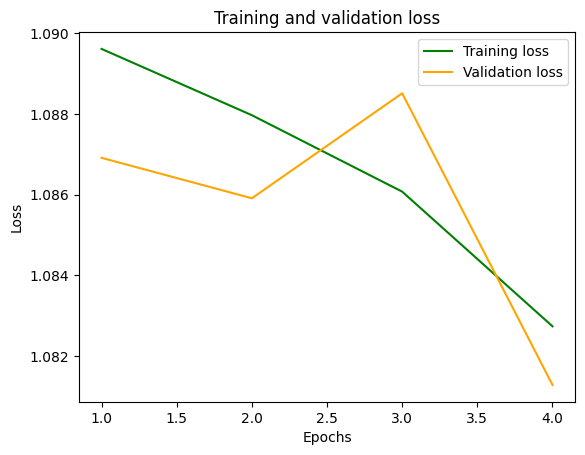

In [74]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


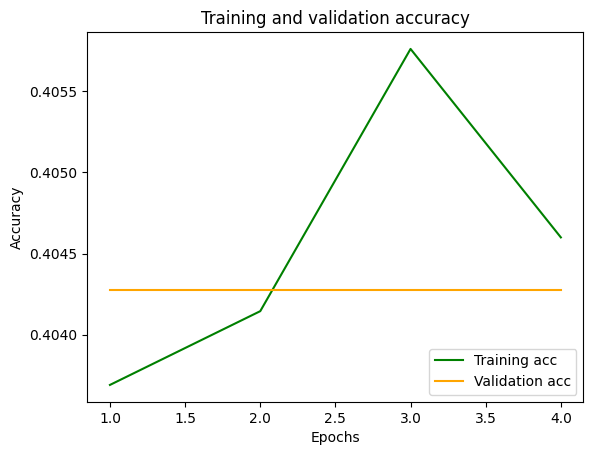

In [75]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

# Using RNN

In [76]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

rnn_model.add(layers.SimpleRNN(128, return_sequences = True))

rnn_model.add(layers.GlobalMaxPool1D())

rnn_model.add(layers.Dense(3, activation = "softmax"))

rnn_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = rnn_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 81s 500ms/step - accuracy: 0.4828 - loss: 0.9993 - val_accuracy: 0.6489 - val_loss: 0.7903 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 396ms/step - accuracy: 0.7285 - loss: 0.6711 - val_accuracy: 0.6558 - val_loss: 0.8052 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 80s 386ms/step - accuracy: 0.8091 - loss: 0.5130 - val_accuracy: 0.7053 - val_loss: 0.7535 - learning_rate: 1.0000e-04
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 83s 391ms/step - accuracy: 0.8360 - loss: 0.4525 - val_accuracy: 0.7053 - val_loss: 0.7700 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 387ms/step - accuracy: 0.8527 - loss: 0.4201 - val_accuracy: 0.6999 - val_loss: 0.7828 - learning_rate: 1.0000e-05
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.8553 - loss: 0.4136 - val_accuracy: 0.7012 - val_loss: 0.7821 - learning_rate: 1.0000e-06


In [77]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6813 - loss: 0.7959
Loss:  0.8035115599632263
Accuracy:  0.6795851588249207


# Simple LSTM model

In [78]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

lstm_model.add(layers.SpatialDropout1D(0.25))

lstm_model.add(layers.LSTM(128, dropout = 0.6, return_sequences = True))

lstm_model.add(layers.GlobalMaxPooling1D())

lstm_model.add(layers.Dense(32, activation = "tanh"))
lstm_model.add(layers.Dense(3, activation = "softmax"))

lstm_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = lstm_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 154s 971ms/step - accuracy: 0.4417 - loss: 1.0448 - val_accuracy: 0.6576 - val_loss: 0.7825 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 203s 976ms/step - accuracy: 0.6820 - loss: 0.7465 - val_accuracy: 0.6962 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 152s 982ms/step - accuracy: 0.7463 - loss: 0.6417 - val_accuracy: 0.7167 - val_loss: 0.7139 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 148s 956ms/step - accuracy: 0.7759 - loss: 0.5699 - val_accuracy: 0.7049 - val_loss: 0.7482 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 152s 984ms/step - accuracy: 0.8061 - loss: 0.5076 - val_accuracy: 0.7185 - val_loss: 0.7369 - learning_rate: 1.0000e-04
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 197s 953ms/step - accuracy: 0.8171 - loss: 0.4878 - val_accuracy: 0.7190 - val_loss: 0.7378 - learning_rate: 1.0000e-05
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 149s 959ms/step 

In [79]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 326ms/step - accuracy: 0.7024 - loss: 0.7648
Loss:  0.7661087512969971
Accuracy:  0.7034206986427307


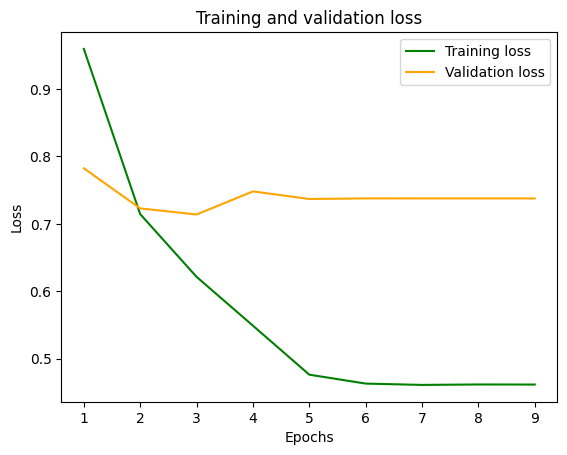

In [80]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

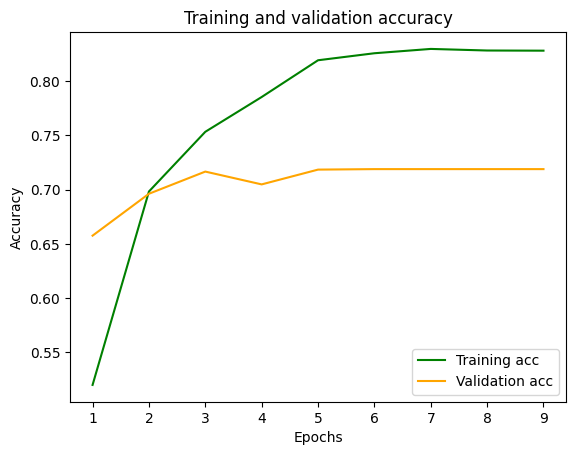

In [81]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [82]:
export_model = Sequential([
  vectorize_layer,
  lstm_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
result = export_model.evaluate(raw_test_ds)
print(accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.7024 - loss: 0.0000e+00
0.7034206986427307


In [83]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)
y_pred = np.argmax(predictions , axis = 1)

y_test = X_test["sentiment"]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test,y_pred, average = None)
recall = recall_score(y_test,y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1556
           1       0.66      0.73      0.69      2223
           2       0.75      0.73      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.70      0.70      5496
weighted avg       0.71      0.70      0.70      5496



In [84]:
lstm_model.save("sentiment_predictor.keras")

In [85]:
# SAVE EXPORT MODEL
export_model.save("sentiment_predictor_vectorized.keras")

In [86]:
def predict_sentiment(text):
  """Predicts the sentiment of a given text.

  Args:
      text: The input text as a raw string.

  Returns:
      An integer representing the predicted sentiment score (0, 1, or 2).
  """
  # Convert the single string into a dataset with one element
  # This is needed for the vectorize_layer to work correctly
  input_data = tf.data.Dataset.from_tensor_slices([text]).batch(1)
  predictions = export_model.predict(input_data)
  print(predictions)
  predicted_class = np.argmax(predictions, axis=1)[0]
  return predicted_class

In [87]:
predict_sentiment("this article is bad")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.8129546  0.18323947 0.00380595]]


0

# Insurance Review

In [88]:
# load model "sentiment_predictor_vectorized.keras"

In [89]:
ins_df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sent Analysis/Insurance Company Review.csv')


In [90]:
ins_df.sample(5)

,Unnamed: 0,Customer Name,Customer Location,Review Text
14008,14008,Rick Bairett,US,I have used proliability for ...
22900,22900,Sarah Hoelscher,US,Coleman Buick got an excellent...
40581,40581,Christine,US,Thought your assistance in loc...
21312,21312,Mo Conter,US,"Easy, fair price."
7819,7819,JPD,US,Log in very cumbersome! Chang...


In [91]:
predict_sentiment(ins_df['Review Text'][1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.01465308 0.21255067 0.7727963 ]]


2

In [92]:
# prompt: get number of rows for ins_df

print(len(ins_df))

44934


In [94]:
# prompt: save model

lstm_model.save("sentiment_predictor.keras")
export_model.save("sentiment_predictor_vectorized.keras")